# Ha 2020 Model: Type 2 diabetes: one disease, many pathways

Ref: https://journals.physiology.org/doi/full/10.1152/ajpendo.00512.2019

Supplement: https://figshare.com/articles/journal_contribution/Mathematical_Model_of_Diabetes_Pathways/10792412

Source code: https://github.com/artielbm/artielbm.github.io/tree/master/Models/Pathways

In [1]:
import tellurium as te
import matplotlib.pyplot as plt

In [2]:

# based on https://github.com/artielbm/artielbm.github.io/blob/master/Models/Pathways/pathway_matlab/pathway.m
r = te.loada("""
species $G; species $I; species $beta; species $sigma; species $M; species $ISR;
# y(1) = G, y(2) = I, y(3) = beta, y(4) = gam, y(5) = sigma, y(6) = si, y(7) = hepasi, y(8) = N5, y(9) = N6

# System parameters
Eg0=0.0118;  BV=7200; unit_con=0.0006944; k=0.4861;

# turning on or off the subsystems - meal, OGTT, IVGTT
meal=1; OGTT=0; IVGTT=0;
averG = 0; GT=1440;

# Define metabolic rate M and Insulin secretion rate ISR
Mmax=1; alpha_M=150; kM=2;
M := Mmax*G^kM/(alpha_M^kM + G^kM);

alpha_ISR=1.2; 
kISR=2;

ts=60; t_min=0.00069444;

# Define exocytosis
# Glucose Amplifying factor

GF_bar=4.4567; kGF=16; alpha_GF=260; shGF=-89; GF_b=1.7826;
GF := (0.1*IVGTT*GF_bar + (1-IVGTT)*GF_bar)*(G-shGF)^kGF/(alpha_GF^kGF + (G-shGF)^kGF) + GF_b;

ca_bar=2; kca=4; alpha_ca=0.62; ca_b=0.07; 
ci := ca_bar*(M + gam)^kca/(alpha_ca^kca + (M + gam)^kca) + ca_b;

k1=20; km1=100; r1=0.6; rm1=1; rm2=0.001;
r20=0.006; 


r30=1.205; rm3=0.0001; u1=2000; u2=3; u3=0.02; Kp2=2.3;

r2 := (0.1*IVGTT*r20 + (1-IVGTT)*r20)*ci/(ci + Kp2);


# Define Microdoman Ca2+
cmd_factor=150; cmd_b=0.0635; cik=4; cialpha=1;
cmd := cmd_factor*ci^cik/(cialpha^cik + ci^cik) + cmd_b;

r3 := sigma*GF*r30*ci/(ci + Kp2);

######
N1_C := km1/(3*k1*cmd + rm1);
N1_D := r1/(3*k1*cmd + rm1);

N2_E := 3*k1*cmd/(2*k1*cmd + km1);
N2_F := 2*km1/(2*k1*cmd + km1);

N3_L := 2*k1*cmd/(2*km1+k1*cmd);
N3_N := 3*km1/(2*km1+k1*cmd);

###### fast-slow analysis by considering N6 and N5 slow and all other fast.
CN4 := (k1*cmd/(3*km1 +u1));
CN3 := N3_L/(1-N3_N*CN4);
CN2 := N2_E/(1-N2_F*CN3);
CN1 := N1_D/(1-N1_C*CN2);


N1 := CN1*N5;
N2 := CN2*N1;
N3 := CN3*N2;
N4 := CN4*N3;
NF := u1*N4/u2;
NR := (u2/u3)*NF;

###### Build b dynamics and Define Proliferation rate P(ISR) and Apoptosis A(M)
         
ISR := ts*9*(u3*NR);
Pmax=4.55; kP=4; alpha_P=41.77;
P := Pmax*ISR^kP/(alpha_P^kP + ISR^kP);

Amax=3.11; alpha_A=0.44; kA=6; A_b=0.8;
A := Amax*M^kA/(alpha_A^kA + M^kA) + A_b;
tau_b = 10080000;

###### Build gam dynamics

Gs = 100;
G_bar=0.4; Gn=5; Gshft=0.2;
G_inf := G_bar/(1 + exp(-(G - Gs)/Gn)) - Gshft;
gam_inf := G_inf;
tau_g = 3081.6;

###### Build sigma dynamics
sigma_Gsh=35;
M_Gsh := Mmax*(G-sigma_Gsh)^kM/(alpha_M^kM + (G-sigma_Gsh)^kM);

ISRI_bar = 1.4; 
ISRI_s=0.1; ISRI_n=0.1; ISRI_k=1; sigma_b=0.01752;

sigma_ISRI := ISRI_bar/(1 + ISRI_k*exp(-(ISR - ISRI_s)/ISRI_n));

MI_bar=1; MI_k=0.2; MI_s=0.2; MI_n=0.02;

sigma_MI :=  1 - MI_bar/(1 + MI_k*exp(-(M_Gsh - MI_s)/MI_n));
sigma_inf := sigma_MI*sigma_ISRI + sigma_b; 

tau_sigma = 359856;

tau_si = 360000;
tar_si = 0.8
####################################

# meal Flux
period=360;
nspike=3;
rest=360;

active := nspike*period;
bperiod := active + rest; 

# mealbar is the average glucose intake in a meal
mealbar=11.055; mhill_k=4; mh_alpha=40; ita=0.3; mu=-0.015;
      
burstenv := ( piecewise(1, time % bperiod > 0, 0) -piecewise(1, time % bperiod > active, 0) );
mhill_fcn := (time % period)^mhill_k/(mh_alpha^mhill_k +(time % period)^mhill_k);
meal_rate :=  meal*(mealbar*(mhill_fcn)^ita*exp(mu*((time % period)))*burstenv);

####


######
# OGTT Flux ## unit [BW]=kg, [V_bar]=dl
BW = 75;
V_bar=1.569; OGTTbar=1; t1=15; 
t2=120; t3=240;
a1=588.5; a2=353.1; a3=0; 
t_g_0 := piecewise(1, time>0, 0);
t_g_t1 := piecewise(1, time>t1, 0);
t_g_t2 := piecewise(1, time>t2, 0);
t_g_t3 := piecewise(1, time>t3, 0);
OGTT_flux0 := (t_g_0 - t_g_t1)*time*a1/t1 + (t_g_t1-t_g_t2)*((time-t2)*(a2-a1)/(t2-t1)+a2) + (t_g_t2-t_g_t3)*(time-t3)*(a3-a2)/(t3-t2);
OGTT_rate := OGTT*OGTTbar*OGTT_flux0/(BW*V_bar);
        
# IVGTT Flux      

IVGTTbar=1471250; IVGTT_sh=0;
IVGTT_a=1; IVGTT_b=-10; 
IVGTT_sp=0;

IVGTT_rate :=  IVGTT*IVGTTbar*(time-IVGTT_sh)^IVGTT_a*exp(IVGTT_b*(time-IVGTT_sp))/(BW*V_bar);

# HGP model
HGP_no_si = 0;
hepa_bar=15.443; hepa_k=0.27; hepa_b=-3.54277; con_si=0.8;
hepa_max := hepa_bar/(hepa_k + si*(1-HGP_no_si) + con_si*HGP_no_si) + hepa_b;
      
alpha_max=6; alpha_k=0.4; alpha_b=-0.5;
alpha_HGP := alpha_max/(alpha_k + si*(1-HGP_no_si) + con_si*HGP_no_si) + alpha_b;

HGP_b=0.104166;  
HGP  := hepa_max/(alpha_HGP + I*hepasi) + HGP_b;

tar_hepasi = 1; tau_hepasi = 360000;

# ode system       

Gmean' = averG*G/GT;
G' = HGP + meal_rate + OGTT_rate + IVGTT_rate - (Eg0 + unit_con*si*I)*G;
I' = beta*ISR/BV  - k*I;  
beta' = (P - A)*beta/tau_b;
gam' = (gam_inf - gam)/tau_g;
sigma' = (sigma_inf - sigma)/tau_sigma;
si' = (-si + tar_si)/tau_si;

hepasi' =(-hepasi+ tar_hepasi)/tau_hepasi;

N5' = ts*(rm1*CN1*N5 - (r1 + rm2)*N5 + r2*N6);
N6' = ts*(r3 + rm2*N5 - (rm3 + r2)*N6);

# initial values
Gmean = 0
G = 78.59159991393697  
I = 5.637556083340107  
beta = 1533.917937647322 
gam = -0.07663502752199285  
sigma = 1
si = 0.8 
hepasi = 1 
N5 = 60.24283727598375 
N6 = 443.394497666619 
""")

In [3]:
r.resetToOrigin()
result = r.simulate(0, 1000, 1000)

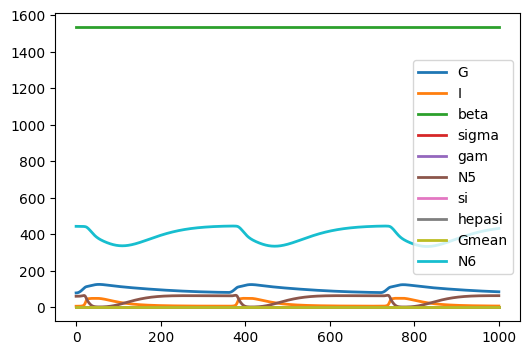

In [4]:
r.plot(result)

## Figure 1

longitudinal, time over several years

Plots: SI, hepasi, Glucose, Insulin, sigma, beta

In [5]:
r.resetToOrigin()
r.setValue('BW', 75)
r.setValue('mealbar', 11.055)
r.setValue('k', 0.4861);

r.setValue('meal', 1)
r.setValue('OGTT', 0)
r.setValue('IVGTT', 0)
r.setValue('r20', 0.006)

r.setValue('tar_si', 0.1)
r.setValue('tau_si', 360000) 
r.setValue('tar_hepasi', 0.85)
r.setValue('tau_hepasi', 360000)
r.setValue('Gs', 100)
r.setValue('ISRI_bar', 0.5259) # beta-cell function defect - default is 1.4.

# y(1) = G, y(2) = I, y(3) = beta, y(4) = gam, y(5) = sigma, y(6) = si, y(7) = hepasi, y(8) = N5, y(9) = N6
init=[78.59, 5.63, 1533.91, -0.07663, 1, 0.8, 1, 60.24, 443.39]
r.setValue('G', 78.59)
r.setValue('I', 5.63)
r.setValue('beta', 1533.91)
r.setValue('gam', -0.07663)
r.setValue('sigma', 1)
r.setValue('si', 0.8)
r.setValue('hepasi', 1)
r.setValue('N5', 60.24)
r.setValue('N6', 443.39)

In [6]:
total_t = 2628000
OGTT_period = 7200
nPeriods = int(total_t/OGTT_period)
dt = 10
tspan = list(range(0, OGTT_period, dt))
tspanOGTT = range(120)

In [7]:
t0 = 0
T = []
Y = []
OGTT_results = []

In [8]:
r.setValue('meal', 0)
r.setValue('OGTT', 1)
results = r.simulate(0, 120, 120)

In [9]:
OGTT_results.append(results)

In [10]:
current_time = 0
for i in range(nPeriods):
    r.setValue('meal', 1)
    r.setValue('OGTT', 0)
    results = r.simulate(0, OGTT_period, int(OGTT_period/dt))
    Y.append(results)
    current_time += results['time'][-1]
    T.append(current_time)
    # print(results['si'][-1])
    # do an OGTT simulation
    r.setValue('meal', 0)
    r.setValue('OGTT', 1)
    results = r.simulate(0, 120, int(120/dt))
    OGTT_results.append(results)

0.7859103964055657
0.7721043884246245
0.7585762678432172
0.7453204413423401
0.7323314281853421
0.7196038579518605
0.7071324683173981
0.6949121028775368
0.6829377090159995
0.6712043358155949
0.6597071320112144
0.6484413439840471
0.6374023137961401
0.6265854772645421
0.6159863620741932
0.605600585928825
0.5954238547390353
0.5854519608468951
0.5756807812862174
0.5661062760779116
0.5567244865596059
0.5475315337488958
0.5385236167395591
0.529697011130048
0.5210480674835684
0.5125732098192167
0.5042689341334473
0.49613180695132775
0.48815846390691064
0.48034560835223455
0.47269000999428334
0.46518850355938685
0.4578379874845346
0.4506354226349821
0.4435778310477061
0.43666229470013856
0.4298859543036836
0.4232460081215246
0.41673971081021577
0.4103643722845994
0.404117356605563
0.39799608089018895
0.39199801424384795
0.3861206767137644
0.3803616382636691
0.3747185177690671
0.3691889820327567
0.3637707448201427
0.35846156591396233
0.3532592501880688
0.34816164669981997
0.3431666478007564
0.33

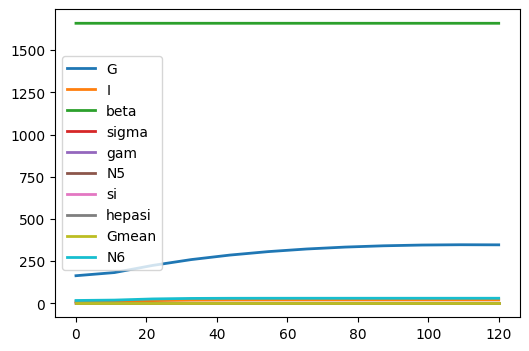

In [11]:
r.plot(results)

In [12]:
# collate all results
end_times = [x['time'][-1] for x in Y]
si_vals = [x['si'][-1] for x in Y]
hepasi_vals = [x['hepasi'][-1] for x in Y]
G_vals = [x['G'][-1] for x in Y]
I_vals = [x['I'][-1] for x in Y]
sigma_vals = [x['sigma'][-1] for x in Y]
beta_vals = [x['beta'][-1] for x in Y]

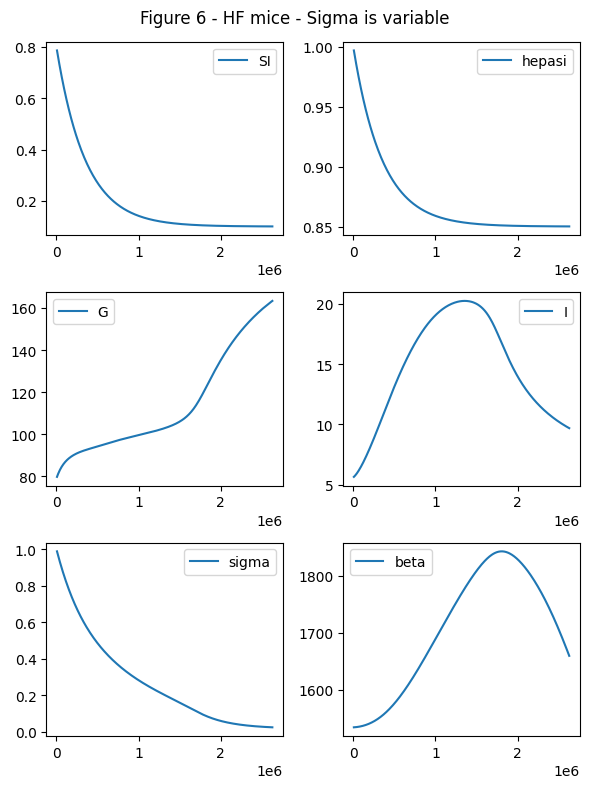

In [17]:
# data required for plotting: si, hepasi, G, I, sigma, beta
fig, axes = plt.subplots(3, 2, figsize=(6, 8))
fig.suptitle('Figure 6 - HF mice - Sigma is variable')
axes[0, 0].plot(T, si_vals, label='SI')
axes[0, 0].legend()
axes[0, 1].plot(T, hepasi_vals, label='hepasi')
axes[0, 1].legend()
axes[1, 0].plot(T, G_vals, label='G')
axes[1, 0].legend()
axes[1, 1].plot(T, I_vals, label='I')
axes[1, 1].legend()
axes[2, 0].plot(T, sigma_vals, label='sigma')
axes[2, 0].legend()
axes[2, 1].plot(T, beta_vals, label='beta')
axes[2, 1].legend()
fig.tight_layout()
fig.show()

In [14]:
T

[7200.0,
 14400.0,
 21600.0,
 28800.0,
 36000.0,
 43200.0,
 50400.0,
 57600.0,
 64800.0,
 72000.0,
 79200.0,
 86400.0,
 93600.0,
 100800.0,
 108000.0,
 115200.0,
 122400.0,
 129600.0,
 136800.0,
 144000.0,
 151200.0,
 158400.0,
 165600.0,
 172800.0,
 180000.0,
 187200.0,
 194400.0,
 201600.0,
 208800.0,
 216000.0,
 223200.0,
 230400.0,
 237600.0,
 244800.0,
 252000.0,
 259200.0,
 266400.0,
 273600.0,
 280800.0,
 288000.0,
 295200.0,
 302400.0,
 309600.0,
 316800.0,
 324000.0,
 331200.0,
 338400.0,
 345600.0,
 352800.0,
 360000.0,
 367200.0,
 374400.0,
 381600.0,
 388800.0,
 396000.0,
 403200.0,
 410400.0,
 417600.0,
 424800.0,
 432000.0,
 439200.0,
 446400.0,
 453600.0,
 460800.0,
 468000.0,
 475200.0,
 482400.0,
 489600.0,
 496800.0,
 504000.0,
 511200.0,
 518400.0,
 525600.0,
 532800.0,
 540000.0,
 547200.0,
 554400.0,
 561600.0,
 568800.0,
 576000.0,
 583200.0,
 590400.0,
 597600.0,
 604800.0,
 612000.0,
 619200.0,
 626400.0,
 633600.0,
 640800.0,
 648000.0,
 655200.0,
 662400.0,
 6